# EDA

In this notebook our goal is to perform a detailed Exploratory Data Analysis in order to better understand the data, the bussiness problem and the challenges before moving into anti-fraud detection solution.

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns 
from scipy import stats
import matplotlib.pyplot as plt 


In [3]:
df = pd.read_csv("https://gist.githubusercontent.com/cloudwalk-tests/76993838e65d7e0f988f40f1b1909c97/raw/295d9f7cb8fdf08f3cb3bdf1696ab245d5b5c1c9/transactional-sample.csv") 

df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['has_cbk'] = df['has_cbk'].map({True:1, False:0}) #Label encoding  
df['ts'] = ((df['transaction_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s"))

## Chargebacks Distribution

In [4]:
df['has_cbk'].value_counts()

has_cbk
0    2808
1     391
Name: count, dtype: int64

## Merchants

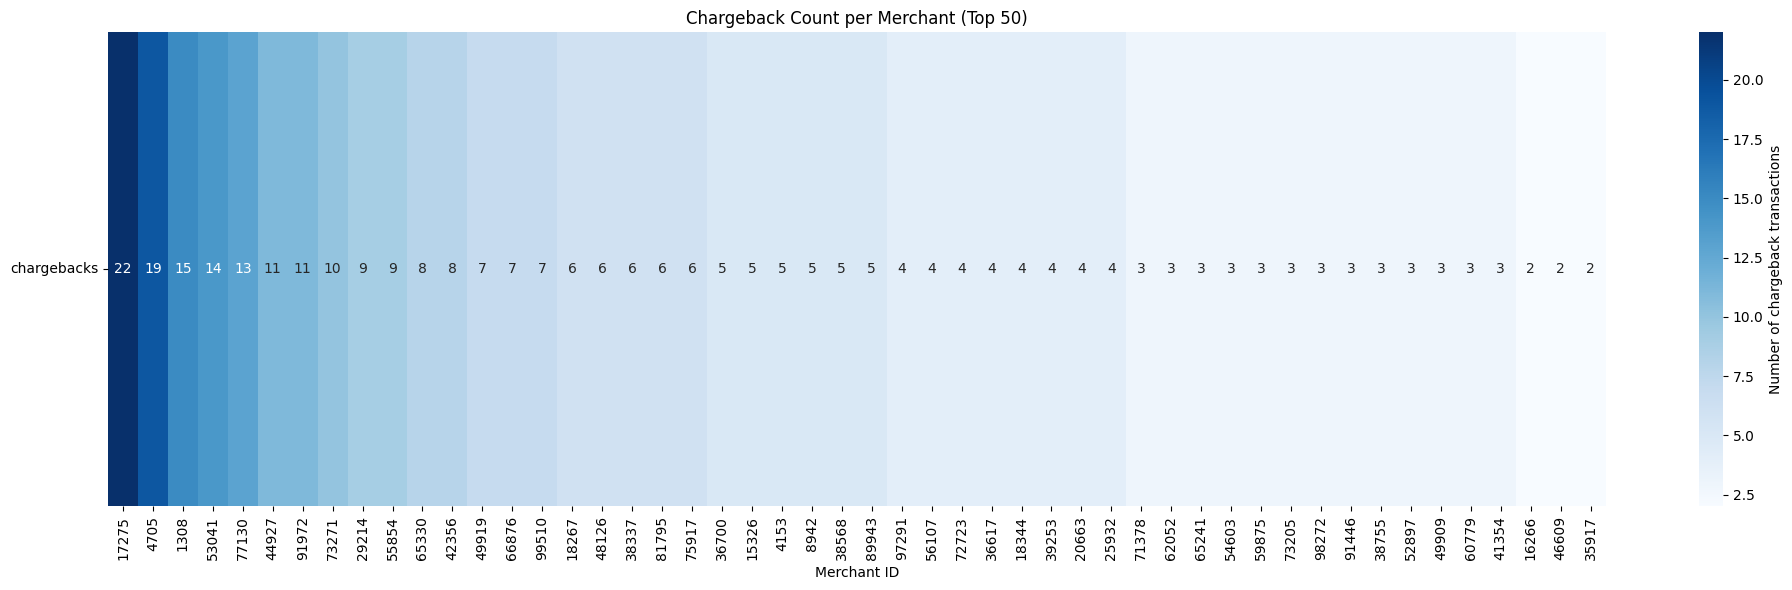

In [5]:
# Heatmap-style plot: chargeback count per merchant
# Filter only chargeback transactions
cbk_counts = (df[df['has_cbk'] == 1]
              .groupby('merchant_id')
              .size()
              .sort_values(ascending=False))

# Limit to top N merchants for readability
top_n = 50
cbk_counts_top = cbk_counts.head(top_n)

# Convert to a 2D structure (1 x N) for a confusion-matrix-like heatmap
heatmap_data = cbk_counts_top.to_frame().T

plt.figure(figsize=(max(14, len(cbk_counts_top) * 0.4), 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar_kws={'label': 'Number of chargeback transactions'}
)

plt.yticks([0.5], ['chargebacks'], rotation=0)
plt.xticks(rotation=90)
plt.xlabel('Merchant ID')
plt.title(f'Chargeback Count per Merchant (Top {len(cbk_counts_top)})')
plt.tight_layout()
plt.show()

In [6]:
df[df['has_cbk'] == 1]['merchant_id'].value_counts().reset_index().head(50)['count'].sum()

np.int64(307)

## Merchants associated with Chargeback

50 merchants are associated with 80% of the chargeback

# Transaction Amount Distribution

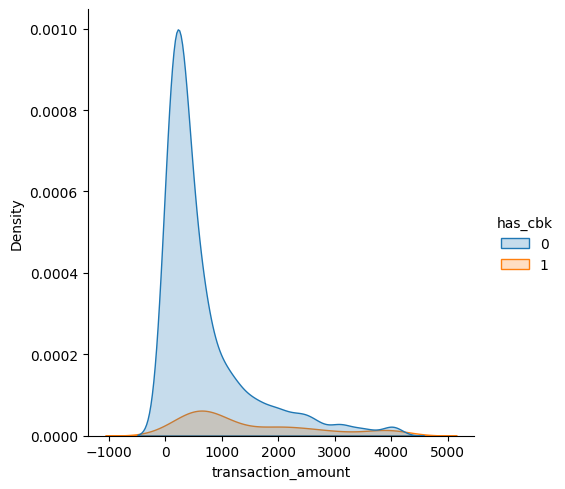

In [7]:
fig = sns.displot(df, x='transaction_amount', hue='has_cbk', kind='kde', fill=True)

# Transaction Time Distribution

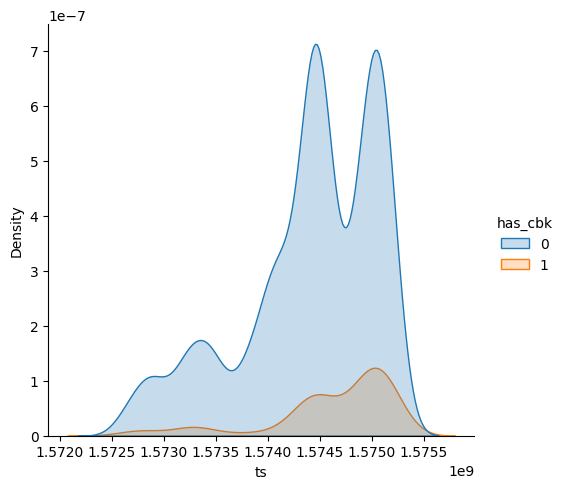

In [8]:
fig = sns.displot(df, x='ts', hue='has_cbk', kind='kde', fill=True)

## User ID

## Splitting up the Users

In [9]:
def get_never_cbk_users():
    never_cbk_filter = df.groupby("user_id")['has_cbk'].sum() == 0 
    never_cbk_df = never_cbk_filter.reset_index() 
    never_cbk_ids = never_cbk_df.query("has_cbk == True")['user_id'] 
    return never_cbk_ids.values

def get_ever_cbk_users():
    ever_cbk_filter = df.groupby("user_id")['has_cbk'].sum() > 0 
    ever_cbk_df = ever_cbk_filter.reset_index() 
    ever_cbk_ids = ever_cbk_df.query("has_cbk == True")['user_id'] 
    return ever_cbk_ids  

In [10]:
def plot_user_time_series(user_ids):
    """
    Plot transaction_amount time series for each user_id in user_ids,
    highlighting chargeback transactions (has_cbk == 1) in red.
    """
    for uid in user_ids:
        user_df = df.query("user_id == @uid").copy()
        if user_df.empty:
            continue

        # Use ts as index and sort by time
        user_ts = user_df.set_index('ts').sort_index()

        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(user_ts.index, user_ts['transaction_amount'], label=f'User {uid} - all transactions')

        # Highlight chargebacks
        cbk_ts = user_ts[user_ts['has_cbk'] == 1]
        if not cbk_ts.empty:
            ax.scatter(cbk_ts.index, cbk_ts['transaction_amount'], color='red', s=30,
                       label='Chargeback (has_cbk = 1)')

        ax.set_xlabel('Timestamp (seconds since 1970-01-01)')
        ax.set_ylabel('Transaction Amount')
        ax.set_title(f'Transaction Amount Time Series for User {uid}')
        ax.legend()
        plt.show()

def plot_random_user_time_series(n_samples, random_state=None):
    """
    Randomly sample user_ids with at least one chargeback and plot their
    transaction_amount time series highlighting chargebacks.

    Parameters
    ----------
    n_samples : int
        Number of distinct user_ids to sample.
    random_state : int or None, optional
        Seed for the random number generator, for reproducibility.
    """
    ever_cbk_users = get_ever_cbk_users()
    if len(ever_cbk_users) == 0:
        print("No users with chargebacks found.")
        return

    n_samples = min(n_samples, len(ever_cbk_users))
    rng = np.random.default_rng(random_state)
    sampled_ids = rng.choice(ever_cbk_users, size=n_samples, replace=False)

    print(f"Plotting {n_samples} users: {list(sampled_ids)}")
    plot_user_time_series(sampled_ids)

# Example usage:
# plot_random_user_time_series(n_samples=5, random_state=42)

In [11]:
cbk_users_array = get_ever_cbk_users()
cbk_users = df.query("user_id in @cbk_users_array")

In [12]:
df_cbk_users = cbk_users.sort_values(by=['user_id', 'transaction_date'])

## Correlations?

In [13]:
stats.pointbiserialr(df['has_cbk'], df['transaction_amount'])

SignificanceResult(statistic=np.float64(0.2878595437974758), pvalue=np.float64(4.363828700651434e-62))

## Feature Engineering

For the feature engineering, we gonna split the datetime into its parts so we better understand the time-date behaviour of each transaction allowing us also to use some of these new variables as features for future models.

We are noticing that we'll need to work with a Time-Series representation of the data.

In [14]:
# Sort by user and time to ensure correct order
df = df.sort_values(['user_id', 'transaction_date', 'has_cbk'])

# Calculate time difference between consecutive transactions for each user
df['time_since_last_transaction'] = df.groupby('user_id')['transaction_date'].diff()
df['last_transaction_amount'] = df.groupby("user_id")['transaction_amount'].shift() 
df['last_transaction_amount_diff'] = df.groupby("user_id")['transaction_amount'].diff()
#number of distinct merchants 
df['number_of_distinct_merchants'] = df.groupby("user_id")['merchant_id'].transform('nunique')
df['ts_diff'] = df.groupby('user_id')['ts'].diff()

# Display the result to verify
df[['user_id', 'transaction_date', 'time_since_last_transaction', 'has_cbk']]

,user_id,transaction_date,time_since_last_transaction,has_cbk
11,6,2019-12-01 20:44:48.109011,NaT,0
3197,7,2019-11-01 01:29:45.799767,NaT,0
3198,8,2019-11-01 01:27:15.811098,NaT,0
3189,19,2019-11-01 17:52:57.071163,NaT,0
390,132,2019-11-30 10:36:29.122871,NaT,0
...,...,...,...,...
1475,99863,2019-11-23 18:36:15.424406,NaT,0
893,99875,2019-11-28 18:26:43.061020,NaT,0
1541,99876,2019-11-23 16:13:33.495480,NaT,1
1255,99948,2019-11-25 19:29:58.020040,NaT,0


In [15]:
time_between_txs = df[['ts_diff', 'has_cbk']][df['ts_diff'].notnull()].reset_index() 

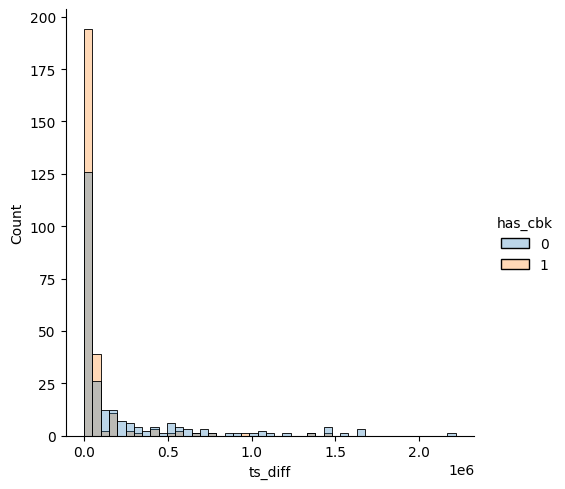

In [16]:
diff_in_txs = sns.displot(time_between_txs, x='ts_diff', hue='has_cbk', alpha=0.3)

## Users

In [17]:
df['user_id'].nunique()
df['user_transactions'] = df.groupby("user_id")['transaction_id'].transform('count')

# Single Transactions Users (Majority)

In [18]:
df_single_txs = df.query("user_transactions == 1")

In [19]:
df_single_txs_has_cbk = df.query("user_transactions == 1 and has_cbk == 1") 

In [20]:
df_single_txs_has_cbk.describe()

,transaction_id,merchant_id,user_id,transaction_date,transaction_amount,device_id,has_cbk,ts,time_since_last_transaction,last_transaction_amount,last_transaction_amount_diff,number_of_distinct_merchants,ts_diff,user_transactions
count,6.400000e+01,64.000000,64.000000,64,64.000000,47.000000,64.0,6.400000e+01,0,0.0,0.0,64.0,0.0,64.0
mean,2.132192e+07,51307.140625,55283.578125,2019-11-23 08:49:01.325245696,1911.728594,505606.553191,1.0,1.574499e+09,NaT,NaN,NaN,1.0,NaN,1.0
min,2.132054e+07,1017.000000,900.000000,2019-11-03 17:02:15.187624,10.470000,6638.000000,1.0,1.572801e+09,NaT,NaN,NaN,1.0,NaN,1.0
25%,2.132119e+07,20652.750000,37017.250000,2019-11-20 19:05:13.225660928,569.635000,284707.500000,1.0,1.574277e+09,NaT,NaN,NaN,1.0,NaN,1.0
50%,2.132208e+07,53041.000000,59840.500000,2019-11-23 01:08:51.188467968,1832.670000,512700.000000,1.0,1.574471e+09,NaT,NaN,NaN,1.0,NaN,1.0
75%,2.132264e+07,82206.000000,79788.750000,2019-11-28 22:18:34.802758912,3076.632500,701284.500000,1.0,1.574980e+09,NaT,NaN,NaN,1.0,NaN,1.0
max,2.132353e+07,99644.000000,99876.000000,2019-12-01 01:50:22.799457,4055.580000,990288.000000,1.0,1.575165e+09,NaT,NaN,NaN,1.0,NaN,1.0
std,9.073516e+02,32344.975731,28924.745780,NaN,1398.191447,284763.950468,0.0,5.834975e+05,NaT,NaN,NaN,0.0,NaN,0.0


### Single Transctions no Chargeback

In [21]:
df_single_txs_no_cbk = df.query("user_transactions == 1 and has_cbk == 0") 

df_single_txs_no_cbk.describe()

,transaction_id,merchant_id,user_id,transaction_date,transaction_amount,device_id,has_cbk,ts,time_since_last_transaction,last_transaction_amount,last_transaction_amount_diff,number_of_distinct_merchants,ts_diff,user_transactions
count,2.405000e+03,2405.000000,2405.000000,2405,2405.000000,1736.000000,2405.0,2.405000e+03,0,0.0,0.0,2405.0,0.0,2405.0
mean,2.132205e+07,49345.268191,50963.628274,2019-11-22 04:18:11.792193536,652.608827,495398.555876,0.0,1.574396e+09,NaT,NaN,NaN,1.0,NaN,1.0
min,2.132040e+07,16.000000,6.000000,2019-11-01 01:27:15.811098,2.110000,4.000000,0.0,1.572572e+09,NaT,NaN,NaN,1.0,NaN,1.0
25%,2.132129e+07,23781.000000,25488.000000,2019-11-18 15:29:38.794281984,192.820000,246168.250000,0.0,1.574091e+09,NaT,NaN,NaN,1.0,NaN,1.0
50%,2.132208e+07,49205.000000,52243.000000,2019-11-23 01:03:21.938266880,354.730000,491621.000000,0.0,1.574471e+09,NaT,NaN,NaN,1.0,NaN,1.0
75%,2.132284e+07,74782.000000,75682.000000,2019-11-28 18:28:59.575816960,775.850000,749599.000000,0.0,1.574966e+09,NaT,NaN,NaN,1.0,NaN,1.0
max,2.132360e+07,99799.000000,99974.000000,2019-12-01 23:16:32.812632,4080.030000,999843.000000,0.0,1.575242e+09,NaT,NaN,NaN,1.0,NaN,1.0
std,9.112898e+02,29016.397527,29076.536334,NaN,761.455247,288135.576687,0.0,6.473997e+05,NaT,NaN,NaN,0.0,NaN,0.0


In [22]:
df_single_txs_no_cbk.quantile(0.81, numeric_only=True)

transaction_id                  2.132301e+07
merchant_id                     8.122900e+04
user_id                         8.167764e+04
transaction_amount              1.052808e+03
device_id                       7.981140e+05
has_cbk                         0.000000e+00
ts                              1.575036e+09
last_transaction_amount                  NaN
last_transaction_amount_diff             NaN
number_of_distinct_merchants    1.000000e+00
ts_diff                                  NaN
user_transactions               1.000000e+00
Name: 0.81, dtype: float64

In [23]:
df_single_txs_has_cbk.quantile(0.38, numeric_only=True)

transaction_id                  2.132155e+07
merchant_id                     3.823878e+04
user_id                         4.445914e+04
transaction_amount              1.043956e+03
device_id                       4.340371e+05
has_cbk                         1.000000e+00
ts                              1.574430e+09
last_transaction_amount                  NaN
last_transaction_amount_diff             NaN
number_of_distinct_merchants    1.000000e+00
ts_diff                                  NaN
user_transactions               1.000000e+00
Name: 0.38, dtype: float64

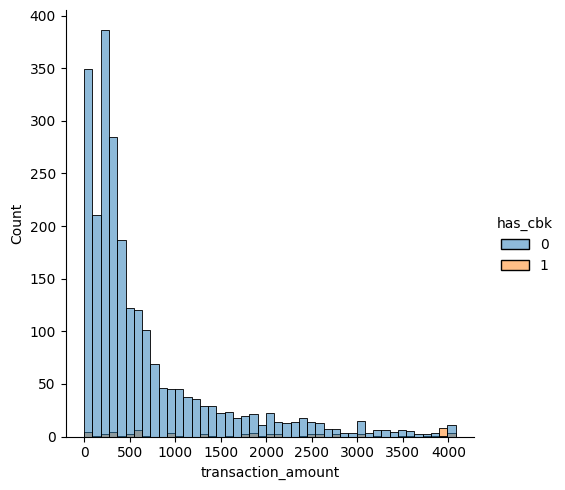

In [24]:
sns.displot(df_single_txs, x = "transaction_amount", hue="has_cbk")

## Users with more than one transaction

In [25]:
multiple_txs_and_cbk = df.query("user_transactions > 1 and has_cbk == 1")
multiple_txs_and_no_cbk = df.query("user_transactions > 1 and has_cbk == 0")

In [26]:
multiple_txs_and_cbk.describe()

,transaction_id,merchant_id,user_id,transaction_date,transaction_amount,device_id,has_cbk,ts,time_since_last_transaction,last_transaction_amount,last_transaction_amount_diff,number_of_distinct_merchants,ts_diff,user_transactions
count,3.270000e+02,327.000000,327.000000,327,327.000000,277.000000,327.0,3.270000e+02,260,260.000000,260.000000,327.000000,2.600000e+02,327.000000
mean,2.132162e+07,45920.798165,52829.486239,2019-11-25 00:15:37.977311488,1363.902110,453735.942238,1.0,1.574641e+09,0 days 16:00:44.107260919,1281.313500,60.780885,1.562691,5.764409e+04,8.620795
min,2.132040e+07,1308.000000,2708.000000,2019-11-01 19:19:50.609011,2.890000,486.000000,1.0,1.572636e+09,0 days 00:00:17.225608,1.300000,-3794.490000,1.000000,1.700000e+01,2.000000
25%,2.132088e+07,17771.000000,18078.000000,2019-11-22 19:27:13.607327488,565.580000,262327.000000,1.0,1.574451e+09,0 days 00:11:47.187994500,534.020000,-139.227500,1.000000,7.080000e+02,3.000000
50%,2.132146e+07,48126.000000,58905.000000,2019-11-27 22:11:06.819239936,963.890000,438940.000000,1.0,1.574893e+09,0 days 00:48:07.117018,859.275000,18.045000,1.000000,2.886500e+03,5.000000
75%,2.132219e+07,68805.000000,79526.000000,2019-11-29 20:59:20.408324864,2040.085000,670695.000000,1.0,1.575061e+09,0 days 14:39:55.033321750,2020.147500,306.775000,2.000000,5.279475e+04,13.000000
max,2.132358e+07,99510.000000,99396.000000,2019-12-01 22:45:37.873639,4097.210000,978084.000000,1.0,1.575240e+09,16 days 18:45:38.942664,4097.210000,3936.630000,4.000000,1.449939e+06,31.000000
std,8.834448e+02,28477.703808,32422.733352,NaN,1099.612791,262753.840456,0.0,6.228242e+05,1 days 22:54:03.172212994,1097.028276,968.399156,0.855270,1.688432e+05,8.464103


In [27]:
multiple_txs_and_no_cbk.describe()

,transaction_id,merchant_id,user_id,transaction_date,transaction_amount,device_id,has_cbk,ts,time_since_last_transaction,last_transaction_amount,last_transaction_amount_diff,number_of_distinct_merchants,ts_diff,user_transactions
count,4.030000e+02,403.000000,403.000000,403,403.000000,309.000000,403.0,4.030000e+02,235,235.000000,235.000000,403.000000,2.350000e+02,403.000000
mean,2.132199e+07,47254.870968,48187.689826,2019-11-22 11:57:10.346542336,789.981712,519895.585761,0.0,1.574424e+09,2 days 08:16:03.255291319,873.889234,-51.187532,1.138958,2.025633e+05,3.699752
min,2.132041e+07,91.000000,266.000000,2019-11-01 10:23:50.555604,1.220000,2.000000,0.0,1.572604e+09,0 days 00:00:23.509238,1.220000,-3367.100000,1.000000,2.400000e+01,2.000000
25%,2.132113e+07,25496.000000,23123.000000,2019-11-18 14:34:39.159119872,164.745000,305347.000000,0.0,1.574088e+09,0 days 00:22:35.082169500,211.335000,-167.165000,1.000000,1.355000e+03,2.000000
50%,2.132197e+07,42178.000000,49106.000000,2019-11-23 14:38:21.445003008,417.660000,534341.000000,0.0,1.574520e+09,0 days 07:47:08.411699,509.700000,0.060000,1.000000,2.802900e+04,2.000000
75%,2.132286e+07,72057.000000,74915.000000,2019-11-29 01:39:48.910817536,1010.455000,735990.000000,0.0,1.574992e+09,2 days 06:23:08.825034500,1091.135000,104.030000,1.000000,1.957890e+05,4.000000
max,2.132359e+07,99730.000000,99850.000000,2019-12-01 20:48:10.921857,4091.830000,991631.000000,0.0,1.575233e+09,25 days 16:23:02.273399,4091.830000,2020.360000,4.000000,2.218983e+06,31.000000
std,9.611086e+02,29466.111461,29618.729628,NaN,978.272630,274516.572743,0.0,6.804666e+05,4 days 08:47:01.256501064,1012.414352,709.153316,0.429678,3.772213e+05,4.295859


# Rule-Based Approach 


### Assumptions

We're assuming that the future data is following the same DGP from the sample we have and that each observation for each User ID is IID.

## Rules to trigger Friction

1. User has at least one previous transactions
    * Time since last transaction is < 50 minutes 
    * Last transaction amount diff is less than or equal to 18 minutes. 
    

2. User has no previous transactions:
    * To-do

# 2 - ML Approach

In [28]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC

## 2.1 Train-Test Split 

We won't do a classical Train-test split because the data is highly imbalanced, and also there's users who has no history of transactions.
So first of all, we'll remove unique transactions users from the training dataset.

For those users we'll treat them differently.

In [29]:
modelling_df = df.query("user_transactions != 1")

81st percentile for has_cbk=0: 1081.2502000000002
38th percentile for has_cbk=1: 726.168


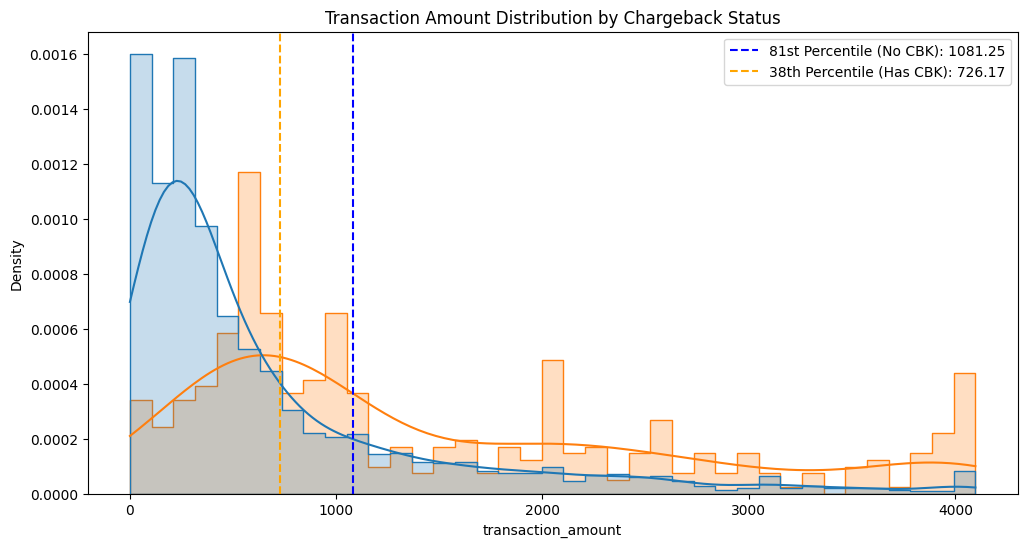

In [30]:
# Calculate quantiles
q81_no_cbk = df[df['has_cbk'] == 0]['transaction_amount'].quantile(0.81)
q38_has_cbk = df[df['has_cbk'] == 1]['transaction_amount'].quantile(0.38)

print(f"81st percentile for has_cbk=0: {q81_no_cbk}")
print(f"38th percentile for has_cbk=1: {q38_has_cbk}")

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='transaction_amount', hue='has_cbk', kde=True, element="step", stat="density", common_norm=False)

# Highlight quantiles
plt.axvline(q81_no_cbk, color='blue', linestyle='--', label=f'81st Percentile (No CBK): {q81_no_cbk:.2f}')
plt.axvline(q38_has_cbk, color='orange', linestyle='--', label=f'38th Percentile (Has CBK): {q38_has_cbk:.2f}')

plt.title('Transaction Amount Distribution by Chargeback Status')
plt.legend()
plt.show()

# 2.0 - Estimating the Transaction Amount Distributions

## Bayesian Approach

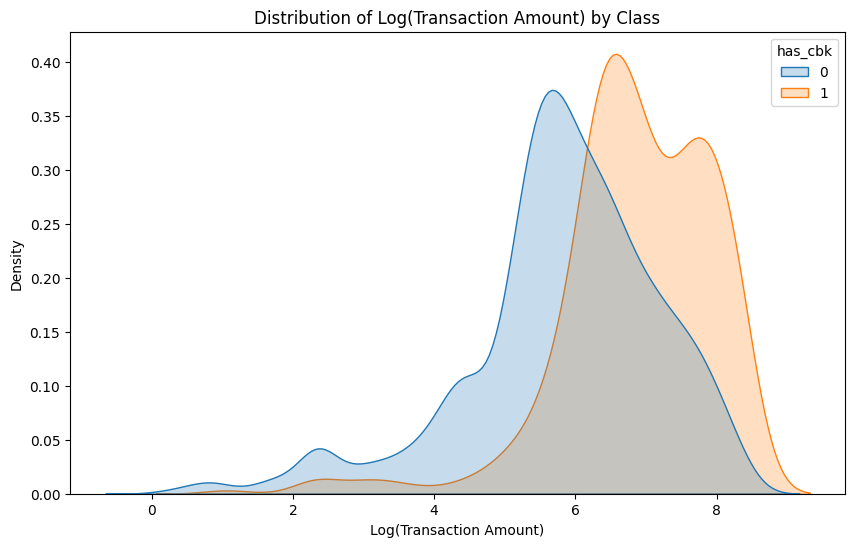

In [31]:
df['log_amount'] = np.log(df['transaction_amount'])

# 2. Visualize to check if they look more "Normal" (Gaussian)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='log_amount', hue='has_cbk', fill=True, common_norm=False)
plt.title('Distribution of Log(Transaction Amount) by Class')
plt.xlabel('Log(Transaction Amount)')
plt.show()

In [32]:
# 3. Estimate Parameters (Mean and Std Dev) for the distributions
# These are the parameters for P(Amount | Class)
mu_legit = df[df['has_cbk'] == 0]['log_amount'].mean()
sigma_legit = df[df['has_cbk'] == 0]['log_amount'].std()

mu_fraud = df[df['has_cbk'] == 1]['log_amount'].mean()
sigma_fraud = df[df['has_cbk'] == 1]['log_amount'].std()

print(f"Legit Transactions (0): mu={mu_legit:.2f}, sigma={sigma_legit:.2f}")
print(f"Fraud Transactions (1): mu={mu_fraud:.2f}, sigma={sigma_fraud:.2f}")

Legit Transactions (0): mu=5.80, sigma=1.40
Fraud Transactions (1): mu=6.86, sigma=1.10


In [33]:
# 4. Calculate Priors P(Class)
# This is the baseline probability of fraud in your dataset
prior_fraud = df['has_cbk'].mean()
prior_legit = 1 - prior_fraud
print(f"Prior Probability of Fraud (Baseline): {prior_fraud:.4%}")


Prior Probability of Fraud (Baseline): 12.2226%


In [34]:
# 5. Define the Bayesian Function
def get_fraud_probability(amount):
    """
    Calculates P(Fraud | Amount) using Bayes' Theorem.
    Assumes Log-Normal distribution of amounts.
    """
    # Transform input to log scale
    log_amt = np.log(amount)
    
    # Calculate Likelihoods: P(Amount | Class)
    # We use the PDF (Probability Density Function) of the Normal distribution
    likelihood_fraud = stats.norm.pdf(log_amt, loc=mu_fraud, scale=sigma_fraud)
    likelihood_legit = stats.norm.pdf(log_amt, loc=mu_legit, scale=sigma_legit)

     # Calculate Evidence (Marginal Likelihood): P(Amount)
    evidence = (likelihood_fraud * prior_fraud) + (likelihood_legit * prior_legit)
    
    # Calculate Posterior: P(Fraud | Amount)
    posterior_fraud = (likelihood_fraud * prior_fraud) / evidence
    
    return posterior_fraud
    

In [35]:
# 6. Test the function with specific amounts
test_amounts = [10, 100, 500, 1000, 2500, 5000]
print("\n--- Probability of Fraud by Amount ---")
for amt in test_amounts:
    prob = get_fraud_probability(amt)
    print(f"Amount: ${amt:<5} -> Fraud Probability: {prob:.2%}")


--- Probability of Fraud by Amount ---
Amount: $10    -> Fraud Probability: 0.08%
Amount: $100   -> Fraud Probability: 3.02%
Amount: $500   -> Fraud Probability: 13.42%
Amount: $1000  -> Fraud Probability: 19.44%
Amount: $2500  -> Fraud Probability: 25.62%
Amount: $5000  -> Fraud Probability: 27.48%


## Using Kernel Density Estimator

In [36]:
# ...existing code...
from scipy.stats import gaussian_kde

# 1. Fit KDE models for both classes
# We still use log_amount because KDE works better when data is not extremely skewed/sparse
# gaussian_kde expects data shape (n_features, n_samples), so we pass the series directly
kde_legit = gaussian_kde(df[df['has_cbk'] == 0]['log_amount'])
kde_fraud = gaussian_kde(df[df['has_cbk'] == 1]['log_amount'])

# 2. Define the Bayesian Function using KDE
def get_fraud_probability_kde(amount):
    """
    Calculates P(Fraud | Amount) using Bayes' Theorem with KDE.
    """
    # Transform input to log scale (since we trained KDE on logs)
    log_amt = np.log(amount)
    
    # Calculate Likelihoods: P(Amount | Class) directly from KDE
    # kde.evaluate returns the density at the given point(s)
    likelihood_fraud = kde_fraud.evaluate(log_amt)[0]
    likelihood_legit = kde_legit.evaluate(log_amt)[0]
    
    # Calculate Evidence (Marginal Likelihood): P(Amount)
    evidence = (likelihood_fraud * prior_fraud) + (likelihood_legit * prior_legit)
    
    # Avoid division by zero if evidence is extremely small
    if evidence == 0:
        return 0.0
        
    # Calculate Posterior: P(Fraud | Amount)
    posterior_fraud = (likelihood_fraud * prior_fraud) / evidence
    
    return posterior_fraud

# 3. Test
print("\n--- Probability of Fraud by Amount (KDE Approach) ---")
test_amounts = [10, 100, 500, 1000, 2500, 5000]
for amt in test_amounts:
    prob = get_fraud_probability_kde(amt)
    print(f"Amount: ${amt:<5} -> Fraud Probability: {prob:.2%}")


--- Probability of Fraud by Amount (KDE Approach) ---
Amount: $10    -> Fraud Probability: 4.24%
Amount: $100   -> Fraud Probability: 2.47%
Amount: $500   -> Fraud Probability: 13.07%
Amount: $1000  -> Fraud Probability: 19.06%
Amount: $2500  -> Fraud Probability: 26.94%
Amount: $5000  -> Fraud Probability: 42.77%


## Time-Since Last Transaction

In [37]:
time_between_txs['log_ts_diff'] = np.log(time_between_txs['ts_diff'])

<Axes: xlabel='log_ts_diff', ylabel='Count'>

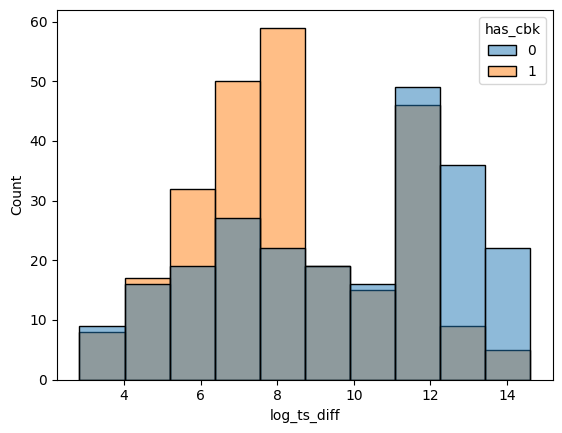

In [38]:
sns.histplot(time_between_txs, hue="has_cbk", x = "log_ts_diff")

In [39]:
# 1. Prepare the data for the second variable (Time Difference)
# Filter out NaNs (first transactions) and infinite values
time_data = time_between_txs.dropna(subset=['log_ts_diff'])
time_data = time_data[np.isfinite(time_data['log_ts_diff'])]

# 2. Fit KDEs for Time Difference
kde_time_legit = gaussian_kde(time_data[time_data['has_cbk'] == 0]['log_ts_diff'])
kde_time_fraud = gaussian_kde(time_data[time_data['has_cbk'] == 1]['log_ts_diff'])

# 3. Update the Bayesian Function to handle two variables
def get_fraud_probability_combined(amount, time_diff=None):
    """
    Calculates P(Fraud | Evidence) using Naive Bayes.
    Evidence can be just Amount, or Amount + TimeSinceLastTransaction.
    """
    # --- 1. Amount Likelihoods ---
    log_amt = np.log(amount)
    # Use the KDEs we trained in the previous step for amounts
    l_amt_fraud = kde_fraud.evaluate(log_amt)[0] 
    l_amt_legit = kde_legit.evaluate(log_amt)[0]
    
    # --- 2. Time Likelihoods (Conditional) ---
    if time_diff is not None and time_diff > 0:
        log_time = np.log(time_diff)
        l_time_fraud = kde_time_fraud.evaluate(log_time)[0]
        l_time_legit = kde_time_legit.evaluate(log_time)[0]
        
        # Combine Likelihoods (Naive Bayes assumption: independence)
        # P(Amount, Time | Class) = P(Amount | Class) * P(Time | Class)
        likelihood_fraud = l_amt_fraud * l_time_fraud
        likelihood_legit = l_amt_legit * l_time_legit
    else:
        # Fallback to just Amount if no history (First transaction)
        likelihood_fraud = l_amt_fraud
        likelihood_legit = l_amt_legit

    # --- 3. Posterior Calculation ---
    evidence = (likelihood_fraud * prior_fraud) + (likelihood_legit * prior_legit)
    
    if evidence == 0: return 0.0
    
    return (likelihood_fraud * prior_fraud) / evidence

In [40]:
#  4. Test scenarios
print("\n--- Combined Probability (Amount + Time) ---")

# Scenario 1: High Amount, Very Short Time (e.g., 60 seconds) - Should be High Risk
p1 = get_fraud_probability_combined(amount=2000, time_diff=60) 
print(f"Amount: $2000, Time: 60s   -> {p1:.2%}")

# Scenario 2: High Amount, Normal Time (e.g., 1 day = 86400s) - Should be Lower Risk
p2 = get_fraud_probability_combined(amount=200, time_diff=7000) 
print(f"Amount: $2000, Time: 1 day -> {p2:.2%}")

# Scenario 3: New User (No time diff)
p3 = get_fraud_probability_combined(amount=2000, time_diff=None)
print(f"Amount: $2000, New User  -> {p3:.2%}")


--- Combined Probability (Amount + Time) ---
Amount: $2000, Time: 60s   -> 22.24%
Amount: $2000, Time: 1 day -> 4.42%
Amount: $2000, New User  -> 23.37%


## Train Test Split

In [118]:
from sklearn.model_selection import train_test_split 

In [134]:
df = pd.read_csv("https://gist.githubusercontent.com/cloudwalk-tests/76993838e65d7e0f988f40f1b1909c97/raw/295d9f7cb8fdf08f3cb3bdf1696ab245d5b5c1c9/transactional-sample.csv") 

df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['has_cbk'] = df['has_cbk'].map({True:1, False:0}) #Label encoding  
df['ts'] = ((df['transaction_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s"))

## Feature Engineering

In [135]:
#  Sort by user and time to ensure correct order
df = df.sort_values(['user_id', 'transaction_date', 'has_cbk'])

# Calculate time difference between consecutive transactions for each user
# df['time_since_last_transaction'] = df.groupby('user_id')['transaction_date'].diff()
df['last_transaction_amount'] = df.groupby("user_id")['transaction_amount'].shift() 
df['last_transaction_amount_diff'] = df.groupby("user_id")['transaction_amount'].diff()
#number of distinct merchants 
df['number_of_distinct_merchants'] = df.groupby("user_id")['merchant_id'].transform('nunique')
df['ts_diff'] = df.groupby('user_id')['ts'].diff()

#Log Features 
# df['log_amount'] = np.log(df['transaction_amount'])
# df['log_ts'] = np.log(df['ts'])

In [136]:
NOT_FEATURES = [
    'user_id',
    'has_cbk',
    'merchant_id',
    'device_id',
    'transaction_date',
    'card_number',
    'transaction_id',
    'ts'
]

In [137]:
X = df.drop(columns=NOT_FEATURES) 
y = df['has_cbk']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df["has_cbk"], test_size=0.10)

In [131]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2879, 8) (2879,)
(320, 8) (320,)


## Complement NaiveBayes

In [142]:
from sklearn.naive_bayes import ComplementNB, GaussianNB 
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curre

In [143]:
y_preds = clf.predict(X_test) 
y_probas = clf.predict_proba(X_test)

In [141]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       281
           1       0.52      0.56      0.54        39

    accuracy                           0.88       320
   macro avg       0.73      0.75      0.74       320
weighted avg       0.89      0.88      0.89       320



Best Recall Score (CV): 73.01%
Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}


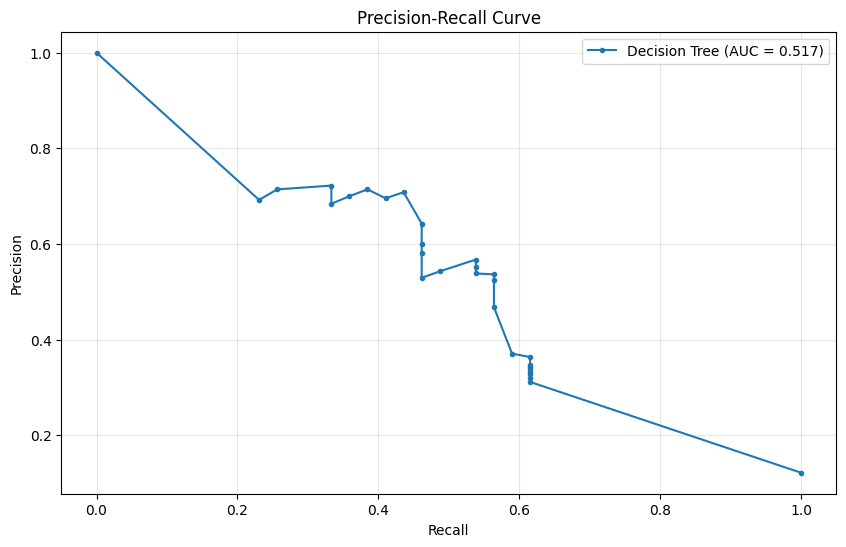

In [147]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve, auc

# 1. Setup Pipeline (Imputer + Classifier)
# We use a constant fill value (e.g., -1) so the Tree can learn "First Transaction" as a specific split
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)), 
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# 2. Define Hyperparameters
param_grid = {
    'classifier__max_depth': [3, 5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced', None] # Important for fraud data
}

# 3. Run Grid Search optimizing for Recall
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    scoring='recall', 
    cv=5, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best Recall Score (CV): {grid_search.best_score_:.2%}")
print(f"Best Parameters: {grid_search.best_params_}")

# 4. Get Probabilities from the best model
best_model = grid_search.best_estimator_
y_scores = best_model.predict_proba(X_test)[:, 1]

# 5. Calculate Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

# 6. Plot
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label=f'Decision Tree (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [148]:
params = {   
            'classifier__class_weight': 'balanced',
             'classifier__max_depth': 20,
             'classifier__min_samples_leaf': 4,
             'classifier__min_samples_split': 10
        }

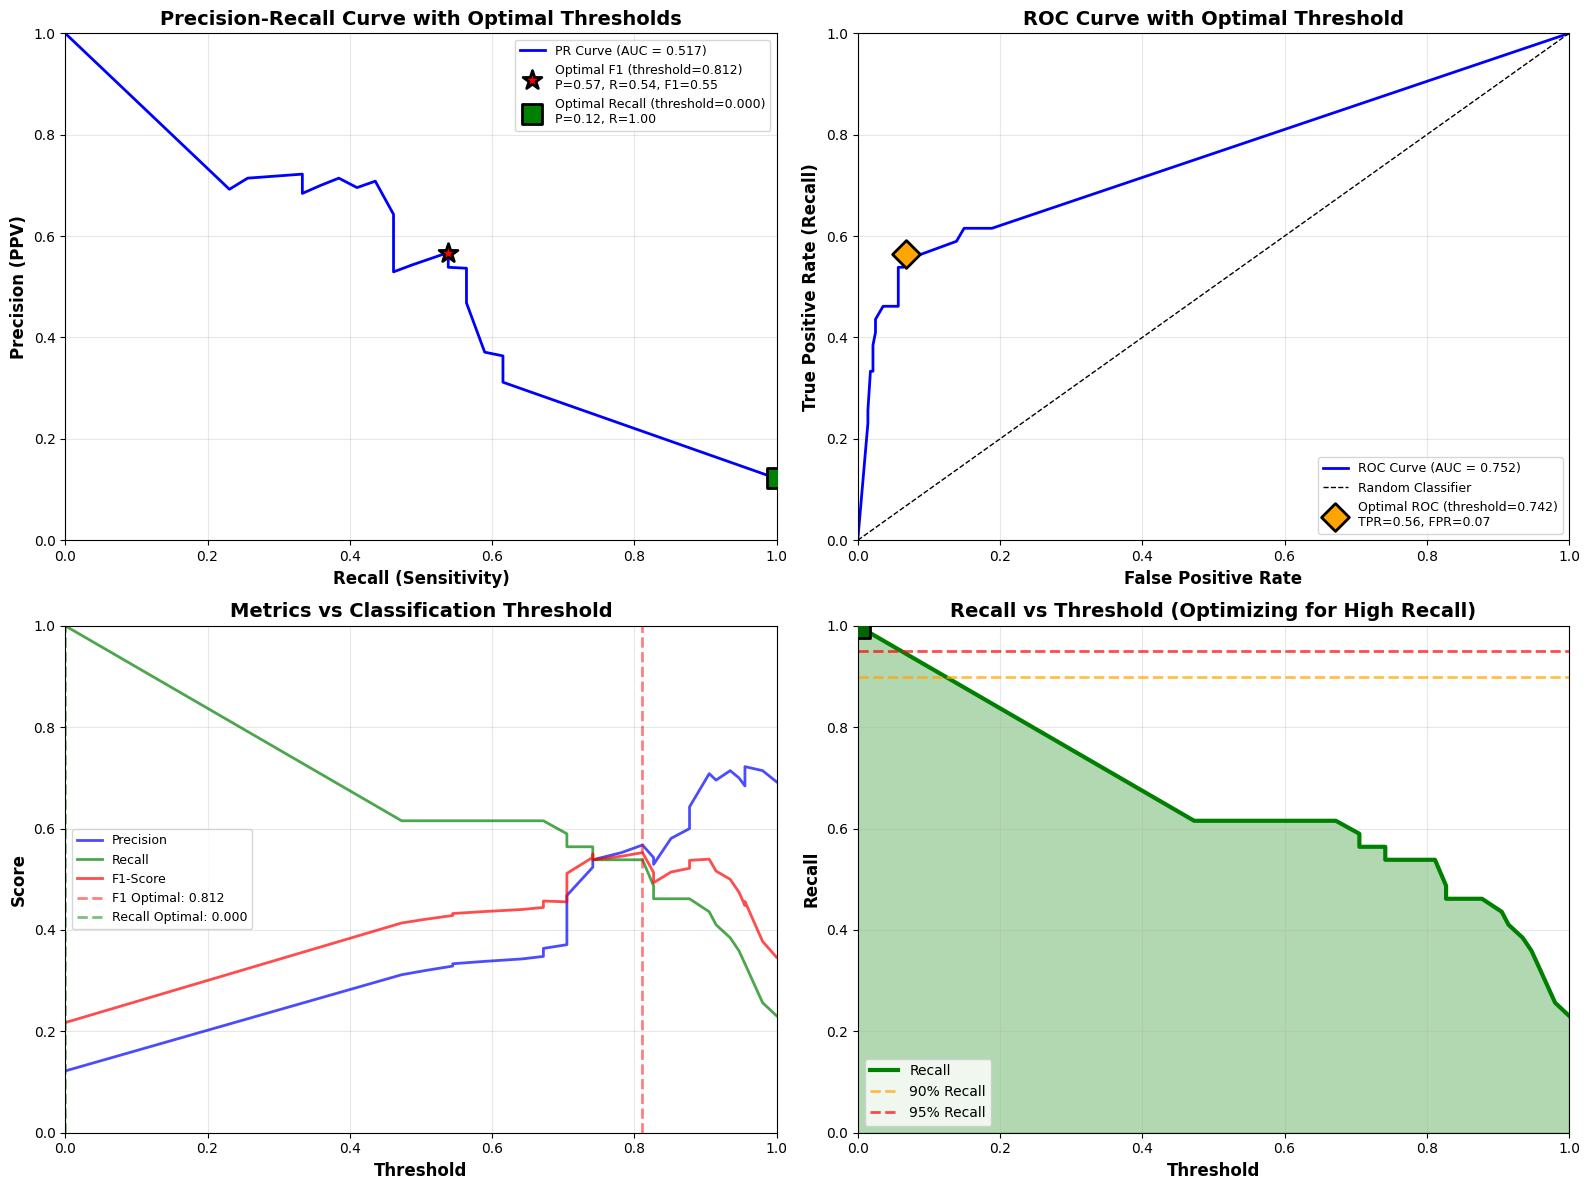


OPTIMAL OPERATING POINTS SUMMARY (Decision Tree)

🎯 RECALL-OPTIMIZED (Recommended for Fraud Detection):
   Threshold: 0.0000
   Recall:    100.00% ← Catches 100.0% of fraud
   Precision: 12.19% ← 12.2% of alerts are real fraud

⚖️  F1-OPTIMIZED (Balanced):
   Threshold: 0.8116
   Recall:    53.85%
   Precision: 56.76%
   F1-Score:  55.26%

📊 ROC-OPTIMIZED (Youden's J):
   Threshold: 0.7417
   TPR (Recall): 56.41%
   FPR:          6.76%

📈 Overall Performance:
   PR-AUC:  0.517
   ROC-AUC: 0.752


In [150]:
# ...existing code...
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

# 1. Train model with best parameters
best_params = {   
    'classifier__class_weight': 'balanced',
    'classifier__max_depth': 20,
    'classifier__min_samples_leaf': 4,
    'classifier__min_samples_split': 10
}

# Recreate pipeline with best params
final_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)), 
    ('classifier', DecisionTreeClassifier(**{k.replace('classifier__', ''): v for k, v in best_params.items()}, random_state=42))
])

final_pipeline.fit(X_train, y_train)
y_scores = final_pipeline.predict_proba(X_test)[:, 1]

# 2. Calculate metrics for different thresholds
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_scores)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)

# Find optimal thresholds
# Optimal for F1
optimal_f1_idx = np.argmax(f1_scores)
optimal_f1_threshold = pr_thresholds[optimal_f1_idx]
optimal_f1_precision = precision[optimal_f1_idx]
optimal_f1_recall = recall[optimal_f1_idx]
optimal_f1_score = f1_scores[optimal_f1_idx]

# Optimal for Recall (we want high recall with reasonable precision)
# Find threshold where recall >= 0.95 (or highest available)
high_recall_mask = recall >= 0.90
if high_recall_mask.any():
    # Among high recall points, pick the one with best precision
    high_recall_indices = np.where(high_recall_mask)[0]
    optimal_recall_idx = high_recall_indices[np.argmax(precision[high_recall_indices])]
else:
    # If no 90% recall, just take highest recall
    optimal_recall_idx = np.argmax(recall[:-1])

optimal_recall_threshold = pr_thresholds[optimal_recall_idx] if optimal_recall_idx < len(pr_thresholds) else pr_thresholds[-1]
optimal_recall_precision = precision[optimal_recall_idx]
optimal_recall_recall = recall[optimal_recall_idx]

# ROC optimal (Youden's J statistic: TPR - FPR)
optimal_roc_idx = np.argmax(tpr - fpr)
optimal_roc_threshold = roc_thresholds[optimal_roc_idx]
optimal_roc_tpr = tpr[optimal_roc_idx]
optimal_roc_fpr = fpr[optimal_roc_idx]

# 3. Create comprehensive plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- Plot 1: Precision-Recall Curve ---
ax1 = axes[0, 0]
pr_auc = auc(recall, precision)
ax1.plot(recall, precision, 'b-', linewidth=2, label=f'PR Curve (AUC = {pr_auc:.3f})')

# Mark optimal points
ax1.scatter(optimal_f1_recall, optimal_f1_precision, s=200, c='red', marker='*', 
            label=f'Optimal F1 (threshold={optimal_f1_threshold:.3f})\nP={optimal_f1_precision:.2f}, R={optimal_f1_recall:.2f}, F1={optimal_f1_score:.2f}',
            edgecolors='black', linewidth=2, zorder=5)

ax1.scatter(optimal_recall_recall, optimal_recall_precision, s=200, c='green', marker='s',
            label=f'Optimal Recall (threshold={optimal_recall_threshold:.3f})\nP={optimal_recall_precision:.2f}, R={optimal_recall_recall:.2f}',
            edgecolors='black', linewidth=2, zorder=5)

ax1.set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Precision (PPV)', fontsize=12, fontweight='bold')
ax1.set_title('Precision-Recall Curve with Optimal Thresholds', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

# --- Plot 2: ROC Curve ---
ax2 = axes[0, 1]
roc_auc = roc_auc_score(y_test, y_scores)
ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

# Mark optimal ROC point
ax2.scatter(optimal_roc_fpr, optimal_roc_tpr, s=200, c='orange', marker='D',
            label=f'Optimal ROC (threshold={optimal_roc_threshold:.3f})\nTPR={optimal_roc_tpr:.2f}, FPR={optimal_roc_fpr:.2f}',
            edgecolors='black', linewidth=2, zorder=5)

ax2.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
ax2.set_title('ROC Curve with Optimal Threshold', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

# --- Plot 3: Threshold vs Metrics ---
ax3 = axes[1, 0]
ax3.plot(pr_thresholds, precision[:-1], 'b-', linewidth=2, label='Precision', alpha=0.7)
ax3.plot(pr_thresholds, recall[:-1], 'g-', linewidth=2, label='Recall', alpha=0.7)
ax3.plot(pr_thresholds, f1_scores, 'r-', linewidth=2, label='F1-Score', alpha=0.7)

# Mark optimal thresholds
ax3.axvline(optimal_f1_threshold, color='red', linestyle='--', linewidth=2, alpha=0.5, label=f'F1 Optimal: {optimal_f1_threshold:.3f}')
ax3.axvline(optimal_recall_threshold, color='green', linestyle='--', linewidth=2, alpha=0.5, label=f'Recall Optimal: {optimal_recall_threshold:.3f}')

ax3.set_xlabel('Threshold', fontsize=12, fontweight='bold')
ax3.set_ylabel('Score', fontsize=12, fontweight='bold')
ax3.set_title('Metrics vs Classification Threshold', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])

# --- Plot 4: Recall Values at Different Thresholds ---
ax4 = axes[1, 1]
ax4.plot(pr_thresholds, recall[:-1], 'g-', linewidth=3, label='Recall')
ax4.fill_between(pr_thresholds, recall[:-1], alpha=0.3, color='green')

# Highlight high recall regions
ax4.axhline(y=0.90, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='90% Recall')
ax4.axhline(y=0.95, color='red', linestyle='--', linewidth=2, alpha=0.7, label='95% Recall')

# Mark the selected optimal recall point
ax4.scatter(optimal_recall_threshold, optimal_recall_recall, s=300, c='darkgreen', marker='s',
            edgecolors='black', linewidth=2, zorder=5)

ax4.set_xlabel('Threshold', fontsize=12, fontweight='bold')
ax4.set_ylabel('Recall', fontsize=12, fontweight='bold')
ax4.set_title('Recall vs Threshold (Optimizing for High Recall)', fontsize=14, fontweight='bold')
ax4.legend(loc='best', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_xlim([0, 1])
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# 4. Print summary of optimal operating points
print("\n" + "="*70)
print("OPTIMAL OPERATING POINTS SUMMARY (Decision Tree)")
print("="*70)
print(f"\n🎯 RECALL-OPTIMIZED (Recommended for Fraud Detection):")
print(f"   Threshold: {optimal_recall_threshold:.4f}")
print(f"   Recall:    {optimal_recall_recall:.2%} ← Catches {optimal_recall_recall:.1%} of fraud")
print(f"   Precision: {optimal_recall_precision:.2%} ← {optimal_recall_precision:.1%} of alerts are real fraud")

print(f"\n⚖️  F1-OPTIMIZED (Balanced):")
print(f"   Threshold: {optimal_f1_threshold:.4f}")
print(f"   Recall:    {optimal_f1_recall:.2%}")
print(f"   Precision: {optimal_f1_precision:.2%}")
print(f"   F1-Score:  {optimal_f1_score:.2%}")

print(f"\n📊 ROC-OPTIMIZED (Youden's J):")
print(f"   Threshold: {optimal_roc_threshold:.4f}")
print(f"   TPR (Recall): {optimal_roc_tpr:.2%}")
print(f"   FPR:          {optimal_roc_fpr:.2%}")

print(f"\n📈 Overall Performance:")
print(f"   PR-AUC:  {pr_auc:.3f}")
print(f"   ROC-AUC: {roc_auc:.3f}")
print("="*70)

## Tuning Threshold

In [153]:
from sklearn.model_selection import TunedThresholdClassifierCV


classifier_tuned = TunedThresholdClassifierCV(
    final_pipeline, scoring="recall"
).fit(X_train, y_train)
print(
    f"Cut-off point found at {classifier_tuned.best_threshold_:.3f}"
)
print(classification_report(y_test, classifier_tuned.predict(X_test)))



Cut-off point found at 0.000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       281
           1       0.12      1.00      0.22        39

    accuracy                           0.12       320
   macro avg       0.06      0.50      0.11       320
weighted avg       0.01      0.12      0.03       320



c:\Users\heito\Desktop\projects\ps\cloudwatch-challenge\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\heito\Desktop\projects\ps\cloudwatch-challenge\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\heito\Desktop\projects\ps\cloudwatch-challenge\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha